# COGS 108 - Final Project

# Overview

In this project, I tried to find the best indicator, acreage of parks or the sentiment score of the review to predict yelp ratings.After using a linear regression model, I found that acres of parks did not significantly predict yelp ratings. While the sentiment score of the review did significantly predict the yelp ratings. 

# Name & GitHub ID

- Name: Jason Alexander Kaharudin
- GitHub Username: Jason-Alex-Kaharudin

# Research Question

Which is a better predictor for yelp ratings, acreage of parks in San Diego or the sentiment score of the review? This analysis will specifically look at parks in San Diego.

## Background and Prior Work

Parks play a key role in the wellfare and wellbeing of people in a community. There are many studies that show that quality parks with good facilities provide numerous health benefits such as reductions in stress, lower blood pressue and improvements to overall fitness. The benefits also cross into the members of the community; world renowned parks known for their beauty such as Balboa Park represents a sense of pride and a positive perception of quality of life for the people in San Diego.

With that said, San Diego's park system can be further improved. "The Trust For Public Land" ranks which cities in the United States have the best parks, ranking San Diego to be #18 for the year 2020 with Minneapolis currently holding the #1 spot. By looking at the top 5 parks, it is noticable that they have high scores in Access (the portion of residents within a 10-minute walking distance to a park), Investment(park spending per resident) and Acreage of parks(how big the park is). With this metric, we can narrow the area of focus for improvement by assessing the relationship between overall satisfaction of parks and acreage of parks. This would give a clear direction to improving San Diego's parks in the next 5 years.


References (include links):

- 1) https://recreation.eku.edu/importance-parks-and-recreation#:~:text=Parks%20and%20protected%20public%20lands,with%20nature%20and%20recreate%20outdoors

- 2) https://www.tpl.org/city/san-diego-california

- 3) https://sharpencx.com/blog/5-minute-customer-satisfaction-analysis/

- 4) https://data.ca.gov/dataset/park-beach-open-space-or-coastline-access
- 5) https://www.nrpa.org/our-work/Three-Pillars/health-wellness/ParksandHealth/fact-sheets/parks-improved-mental-health-quality-life/

# Hypothesis

I suspect that both acreage of parks and the sentiment of the review will be strong predictors of the yelp rating. I speculate that an increase in park acreage will allow the parks and recreation department to see an increase in overall satisfaction of parks, that is yelp ratings that are scored 4 or 5 out of a possible score of 5. This is because I assume that bigger parks would provide visitors with many facilities.

# Dataset(s)

The ideal dataset would show the factors influencing perceptions of parks in San Diego. Factors such as accessibility of parks, different types of amenities and acreage of parks would be ideal variables to measure against the perception of residents. The perception of parks can be obtained through yelp reviews of parks in San Diego. The ideal dataset would conist of an overall rating, out of 5 and review text for sentiment analysis.

The measurement of perception/attitudes would take the approach similar to that of customer satisfaction(CSAT) analysis. This will help us empirically measure perception/attitudes. Budget and expenditure of respective parks and recreation departments will also be useful in explaining the variable of the investment aspect. Ideally, 50 observations of these variables from the top 50 in the ParkScore ranking would help us identify what the top cities are doing right and not doing enough. Park locations in a geojson format will also be useful. This will allow us to visually understand how big parks are and thus find a relationship with the ratings of the park. The data would be in an organized csv file that can be easily processed into a data frame. Geojson files will also be easily processed for data wrangling and visualization. 


- Dataset Name: Yelp data for parks in San Diego
- Link to the dataset: https://www.yelp.com/developers/documentation/v3/business_reviews
- Number of observations: 2333 observations

This dataset provides reviews for individual parks in San Diego. It includes the rating (out of 5) and a review in text. 

- Dataset Name: San Diego parks locations data
- Link to the dataset: https://data.sandiego.gov/datasets/park-locations/
- Number of observations: 2769 observations

This dataset provides location data for parks in San Diego in geojson format. 

- Dataset Name: San Diego boundary map
- Link to the dataset: https://data.sandiego.gov/datasets/san-diego-boundary/
- Number of observations: 5 observations

This dataset provides the boundaries for San Diego in geojson format.


I plan to combine the parks location dataset and yelp review dataset by the park name. So each park name that exists in both datasets will be the finalized observations used for analysis. The San Diego boundary map will be used for visualization purposese.

# Setup

In [1]:
#libraries needed for final project
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Data Cleaning

Include cells that describe the steps in your data analysis

In [2]:
#load the datasets for analysis
parkLoc_df = gpd.read_file("parks_datasd.geojson")
yelp_df = pd.read_csv('yelp_SD_reviews.csv')
# import sd map for background
sd_map = gpd.read_file('san_diego_boundary_datasd.geojson')

## Dropping columns & Cleaning

In order to make the dataset more manageable, I will drop the columns with information that I will not be using in the analysis. The Yelp reviews dataset already have sufficient and related columns for this analysis, so that will be left unchanged. On the other hand, the parks data for San Diego has some columns that are not necessary for this analysis. These columns are noted below.

In [3]:
parkLoc_df = parkLoc_df.drop(['name','objectid','location','owner'], axis = 1)

In [4]:
parkLoc_df.head()

,alias,gis_acres,park_type,geometry
0,South Carlsbad State Beach,115.895878,State,"MULTIPOLYGON (((-117.31431 33.09015, -117.3142..."
1,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9..."
2,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7..."
3,Tuna Harbor Park,0.639035,Local,"POLYGON ((-117.17260 32.71160, -117.17268 32.7..."
4,San Diego Bayfront Park,3.669272,Local,"MULTIPOLYGON (((-117.16074 32.70407, -117.1594..."


## Merging Dataframes

Once I have dropped the columns with information that will not be used in the analysis, I will merge the two datasets based on each park name. Note that in doing so, some observations from the parks dataset will be lost. The observations that are not in the merged dataset means that there is no review associated with the given park or there is no associated park location for the given review. 

Column names will also be renamed to names with simple and clear descriptions. Note that for the column name 'geometry', I will leave unchange, for visualization purposes. With that said, the geometry column holds POLYGON data that maps a geographical location for the given observation.

In [5]:
parkLoc_df.rename(columns={'alias':'Park_Name', 'gis_acres': 'Acres'}, inplace= True)
yelp_df.rename(columns={'id':'Park_Name', 'rating':'Yelp_Rating', 'text': 'Review_Text'}, inplace = True)


main_df = pd.merge(parkLoc_df, yelp_df, on=['Park_Name'])
main_df = main_df.dropna()

main_df

,Park_Name,Acres,park_type,geometry,Yelp_Rating,Review_Text
0,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,Torrey Pines State Beach has a special place i...
1,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",4,Beautiful beach. Easy access and was easy to f...
2,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,"As soon as we arrived at the beach to park, it..."
3,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",3,A pleasant park along a beautiful waterfront t...
4,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",5,I visited a few times on my recent trip to San...
...,...,...,...,...,...,...
535,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",5,Definitely worth the price of admission.\n\nIf...
536,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",4,Well First I got here and I was quite amazed a...
537,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",5,The sports facility here is awesome! It's a pr...
538,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",4,"The location have two parks, one is 4s communi..."


Before any other analysis, I will first perform a sentiment analysis on the given review text for each observation. I will be using the 'SentimentIntensityAnalyzer()' function from the nltk library to analyze the sentiment of the review. This sentiment score will be stored in a new column.

In [6]:
### Sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jkaharud/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
main_df['Scores'] = main_df['Review_Text'].apply(lambda x: analyzer.polarity_scores(x))
main_df

,Park_Name,Acres,park_type,geometry,Yelp_Rating,Review_Text,Scores
0,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,Torrey Pines State Beach has a special place i...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp..."
1,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",4,Beautiful beach. Easy access and was easy to f...,"{'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compou..."
2,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,"As soon as we arrived at the beach to park, it...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",3,A pleasant park along a beautiful waterfront t...,"{'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp..."
4,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",5,I visited a few times on my recent trip to San...,"{'neg': 0.064, 'neu': 0.848, 'pos': 0.088, 'co..."
...,...,...,...,...,...,...,...
535,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",5,Definitely worth the price of admission.\n\nIf...,"{'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'comp..."
536,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",4,Well First I got here and I was quite amazed a...,"{'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'comp..."
537,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",5,The sports facility here is awesome! It's a pr...,"{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'comp..."
538,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",4,"The location have two parks, one is 4s communi...","{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."


The scores column stores the result of the sentiment analyzer. Showing the negative, positive, neutral and compound score of the text review. However, we are only interested in the compound score which represents the overall sentiment of the review. Thus we will be adding a new column to store that value and removing the Scores column.

In [8]:
main_df['Sentiment_Score'] = main_df['Scores'].apply(lambda score_dict: score_dict['compound'])
main_df.head()

,Park_Name,Acres,park_type,geometry,Yelp_Rating,Review_Text,Scores,Sentiment_Score
0,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,Torrey Pines State Beach has a special place i...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.5267
1,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",4,Beautiful beach. Easy access and was easy to f...,"{'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compou...",0.9081
2,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,"As soon as we arrived at the beach to park, it...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",3,A pleasant park along a beautiful waterfront t...,"{'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'comp...",0.9168
4,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",5,I visited a few times on my recent trip to San...,"{'neg': 0.064, 'neu': 0.848, 'pos': 0.088, 'co...",0.1935


In [9]:
main_df = main_df.drop(['Scores'], axis = 1)
main_df

,Park_Name,Acres,park_type,geometry,Yelp_Rating,Review_Text,Sentiment_Score
0,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,Torrey Pines State Beach has a special place i...,0.5267
1,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",4,Beautiful beach. Easy access and was easy to f...,0.9081
2,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,"As soon as we arrived at the beach to park, it...",0.0000
3,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",3,A pleasant park along a beautiful waterfront t...,0.9168
4,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",5,I visited a few times on my recent trip to San...,0.1935
...,...,...,...,...,...,...,...
535,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",5,Definitely worth the price of admission.\n\nIf...,0.9423
536,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",4,Well First I got here and I was quite amazed a...,0.6801
537,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",5,The sports facility here is awesome! It's a pr...,0.8221
538,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",4,"The location have two parks, one is 4s communi...",0.4939


Before moving on to further cleaning, check for any null or none values in the dataset

In [10]:
main_df.isnull().any()

Park_Name          False
Acres              False
park_type          False
geometry           False
Yelp_Rating        False
Review_Text        False
Sentiment_Score    False
dtype: bool

Since there are multiple reviews per park, I will take the average Yelp rating for each park and store it in a new column. It is not possible to add the Yelp ratings to form a joint rating since Yelp ratings are at a maximum score of 5. I will also be averaging the sentiment score of the review for each park.

In [11]:
table = pd.pivot_table(main_df, values = ['Yelp_Rating', 'Sentiment_Score'], index =['Park_Name'])
table.rename(columns = {'Yelp_Rating' : 'Average_Rating', 'Sentiment_Score': 'Average_Sentiment'}, inplace = True)

table

,Average_Sentiment,Average_Rating
Park_Name,,
4S Ranch Community Park,0.754533,4.666667
Ashley Falls Park,0.531300,4.500000
Balboa Park,0.752533,5.000000
Big Rock Park,0.668733,4.333333
Black Mountain Open Space Park,0.336667,4.333333
...,...,...
Vista Pacifica Park,0.361200,4.000000
Waterfront Park,0.802300,4.666667
Western Hills Park,0.176967,3.333333


In [12]:
df = pd.merge(main_df, table, on=['Park_Name'])
df = df.drop(['Sentiment_Score'], axis = 1)
df

,Park_Name,Acres,park_type,geometry,Yelp_Rating,Review_Text,Average_Sentiment,Average_Rating
0,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,Torrey Pines State Beach has a special place i...,0.478267,4.666667
1,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",4,Beautiful beach. Easy access and was easy to f...,0.478267,4.666667
2,Torrey Pines State Beach,67.294309,State,"POLYGON ((-117.26147 32.93883, -117.26181 32.9...",5,"As soon as we arrived at the beach to park, it...",0.478267,4.666667
3,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",3,A pleasant park along a beautiful waterfront t...,0.685700,4.333333
4,Ruocco Park,3.312526,Local,"POLYGON ((-117.17298 32.71167, -117.17303 32.7...",5,I visited a few times on my recent trip to San...,0.685700,4.333333
...,...,...,...,...,...,...,...,...
535,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",5,Definitely worth the price of admission.\n\nIf...,0.802300,4.666667
536,Waterfront Park,12.693865,Regional,"POLYGON ((-117.17156 32.72450, -117.17280 32.7...",4,Well First I got here and I was quite amazed a...,0.802300,4.666667
537,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",5,The sports facility here is awesome! It's a pr...,0.754533,4.666667
538,4S Ranch Community Park,3.241830,Local,"POLYGON ((-117.11610 33.00321, -117.11583 33.0...",4,"The location have two parks, one is 4s communi...",0.754533,4.666667


In [13]:
agg_function = {'Acres':'first', 'park_type':'first', 'Review_Text': 'first', 'geometry': 'first', 'Average_Rating': 'first', 'Average_Sentiment': 'first'}

clean_df = df.sort_values('Park_Name').groupby(['Park_Name', 'Yelp_Rating']).aggregate(agg_function)
clean_df

Acres park_type  \
Park_Name               Yelp_Rating                          
4S Ranch Community Park 4               3.241830     Local   
                        5               3.241830     Local   
Ashley Falls Park       4              11.660442     Local   
                        5              11.660442     Local   
Balboa Park             5            1089.476460  Regional   
...                                          ...       ...   
Western Hills Park      2              12.823290     Local   
                        4              12.823290     Local   
Westview Park           4               8.645989     Local   
Windwood Park           3               1.173010     Local   
                        4               1.173010     Local   

                                                                           Review_Text  \
Park_Name               Yelp_Rating                                                      
4S Ranch Community Park 4            The location have two parks, one is 4s communi...   
                        5            Great park for kids. Large playground plus eas...   
Ashley Falls Park       4            came here for a kids birthday party...not my f...   
                        5            New playground for my 4 yo and 10month old. Bu...   
Balboa Park             5            Balboa Park is a must see when coming to San D...   
...                                                                                ...   
Western Hills Park      2            I almost got a ticket there for having my dog ...   
                        4            Hey now, who doesn't like a nice park? This is...   
Westview Park           4            This park is literally across the street from ...   
Windwood Park           3            My dog found it unbelievable that this park wa...   
                        4            Kind of hard to find if you don't live in the ...   

                                                                              geometry  \
Park_Name               Yelp_Rating                                                      
4S Ranch Community Park 4            POLYGON ((-117.11610 33.00321, -117.11583 33.0...   
                        5            POLYGON ((-117.11610 33.00321, -117.11583 33.0...   
Ashley Falls Park       4            POLYGON ((-117.20788 32.95706, -117.20788 32.9...   
                        5            POLYGON ((-117.20788 32.95706, -117.20788 32.9...   
Balboa Park             5            MULTIPOLYGON (((-117.15296 32.74370, -117.1529...   
...                                                                                ...   
Western Hills Park      2            POLYGON ((-117.19465 32.78693, -117.19495 32.7...   
                        4            POLYGON ((-117.19465 32.78693, -117.19495 32.7...   
Westview Park           4            POLYGON ((-117.11933 32.92419, -117.12114 32.9...   
Windwood Park           3            POLYGON ((-117.22491 32.94784, -117.22490 32.9...   
                        4            POLYGON ((-117.22491 32.94784, -117.22490 32.9...   

                                     Average_Rating  Average_Sentiment  
Park_Name               Yelp_Rating                                     
4S Ranch Community Park 4                  4.666667           0.754533  
                        5                  4.666667           0.754533  
Ashley Falls Park       4                  4.500000           0.531300  
                        5                  4.500000           0.531300  
Balboa Park             5                  5.000000           0.752533  
...                                             ...                ...  
Western Hills Park      2                  3.333333           0.176967  
                        4                  3.333333           0.176967  
Westview Park           4                  4.000000           0.702067  
Windwood Park           3                  3.666667           0.504333  
                  

Finally, checking for null values again just to be sure:

In [14]:
clean_df.isnull().any()

Acres                False
park_type            False
Review_Text          False
geometry             False
Average_Rating       False
Average_Sentiment    False
dtype: bool

# Data Analysis & Results

## Data Visualization

To get a better understanding of the data, it is useful to plot some visualizations. I will be using a choropleth map to show the acreage of parks across San Diego. Scatterplots will also be used to show a general, bird's eye view of the data.

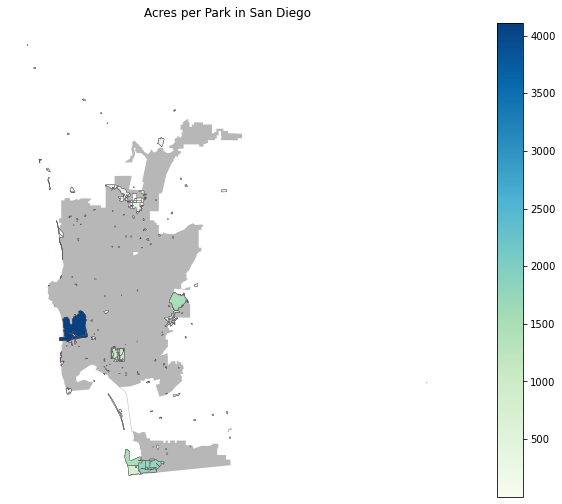

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize = (10,16))
ax.set_title('Acres per Park in San Diego')
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sd_map.plot(ax=ax, color='#B7B7B7')
main_df.plot(column='Acres', 
             ax = ax,
             cmap = 'GnBu',
             legend = True,
             cax = cax,
             edgecolor='#5C5160',
             linewidth=0.4
            )

Figure 1: Choropleth map of parks in San Diego. Darker colors correspond to a park with high acres while lighter colors correspond to parks with low acres. 

In [16]:
clean_df.describe()

,Acres,Average_Rating,Average_Sentiment
count,216.000000,216.000000,216.000000
mean,98.575233,4.038272,0.477488
std,457.168375,0.731009,0.245006
min,0.455256,1.000000,-0.636900
25%,3.312526,3.666667,0.331800
50%,8.617300,4.333333,0.491560
75%,14.760567,4.666667,0.658117
max,4108.397150,5.000000,0.940633


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d4c584110>,
      dtype=object)

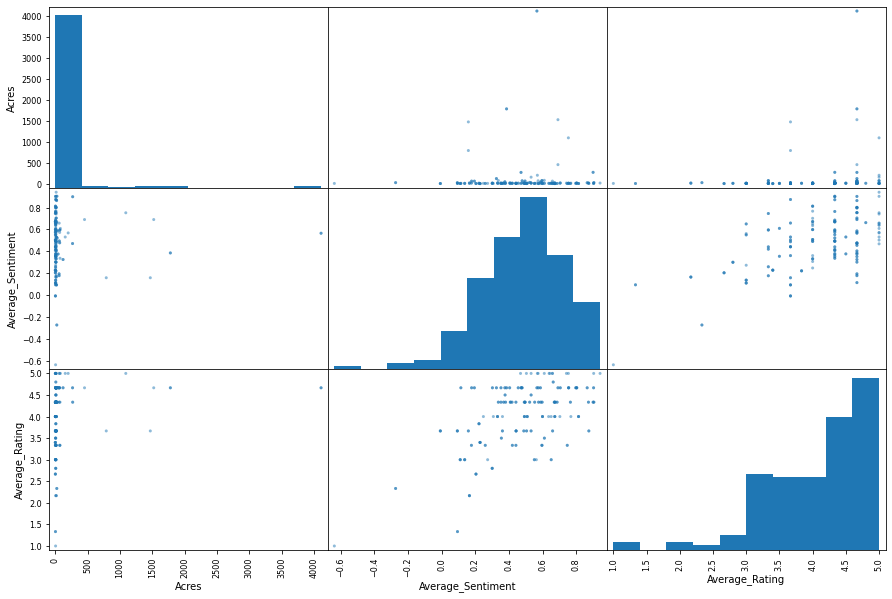

In [17]:
pd.plotting.scatter_matrix(clean_df[['Acres','Average_Sentiment', 'Average_Rating']], figsize = (15,10))

Figure 2: Scatterplot matrix of the imporant columns in main_df.

As we can see from figure 2, the average rating for the parks are generally in the high values (above 3.0). The parks in San Diego also cluster around the 0-1500 acres, with an outlier of 4000 acres. We can also see that the average sentiment score is around 0.4-06.

These observations are also confirmed by the useful tool provided by the pandas library: the parks in San Diego does not have an even spread in terms of acres. We see that there is a high of 4108.39 acres with a mean of 98.57 acres and a high standard deviation of 457.16 acres. Average sentiment score has a mean of 0.477 and a standard deviation of 0.245

Text(0, 0.5, 'frequency')

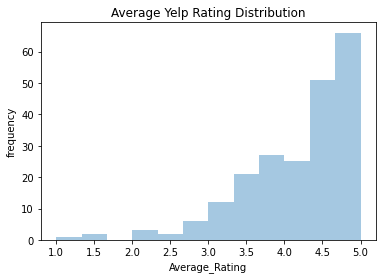

In [18]:
ax = sns.distplot(clean_df['Average_Rating'], kde=False)
ax.set_title('Average Yelp Rating Distribution')
ax.set_ylabel('frequency')

Figure 3: Distribution of average Yelp rating

Text(0, 0.5, 'frequency')

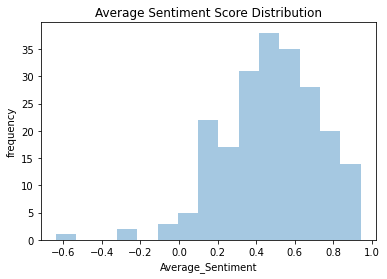

In [19]:
ax = sns.distplot(clean_df['Average_Sentiment'], kde=False)
ax.set_title('Average Sentiment Score Distribution')
ax.set_ylabel('frequency')

Figure 4: Distribution of review lengths

Text(0, 0.5, 'frequency')

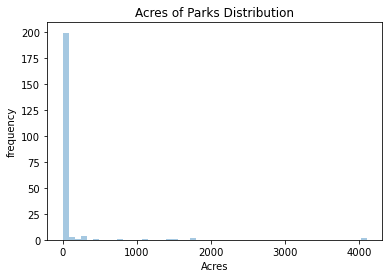

In [20]:
ax = sns.distplot(clean_df['Acres'], kde=False)
ax.set_title('Acres of Parks Distribution')
ax.set_ylabel('frequency')

Figure 5: Distribution of acres of parks in San Diego

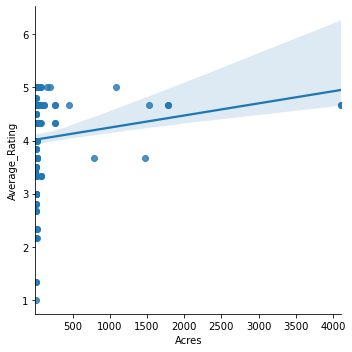

In [21]:
sns.lmplot(x = 'Acres', y = 'Average_Rating', data = clean_df)

Figure 6: Plot of acres against average Yelp rating with an autogenerated line of best fit provided by sns library

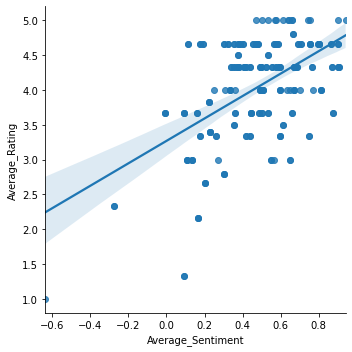

In [22]:
sns.lmplot(x = 'Average_Sentiment', y = 'Average_Rating', data = clean_df)

Figure 7: Plot of review length against average Yelp rating with an autogenerated line of best fit provided by sns library

## Linear Regression
For this analysis, I will use a linear regression model to identify relationship between review lengths on Yelp and acres of a park with the average Yelp rating. This model can also be used as a predictive analysis. The function check_p_val will asses whether or not to reject or accept the null hypothesis. For each model, the null hypothesis will suggest that the given indicator is not a good predictor for average Yelp rating.

In [23]:
def check_p_val(p_val, alpha):

    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

##  Linear model(1) will plot Acres against Average rating

In [24]:
outcome, predictors = patsy.dmatrices('Average_Rating ~ Acres', clean_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Rating   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.433
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0364
Time:                        20:43:41   Log-Likelihood:                -236.10
No. Observations:                 216   AIC:                             476.2
Df Residuals:                     214   BIC:                             482.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0158      0.050     79.544      0.0

From the results of the first model, we can see that the P-value of acres is 0.036.

In [ ]:
check_p_val(0.036, 0.01)

##  Linear model(2) will plot review length against Average rating

In [25]:
outcome, predictors = patsy.dmatrices('Average_Rating ~ Average_Sentiment', clean_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Rating   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     88.11
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           9.46e-18
Time:                        20:43:43   Log-Likelihood:                -201.07
No. Observations:                 216   AIC:                             406.1
Df Residuals:                     214   BIC:                             412.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.2689      0.09

From the results of the first model, we can see that the P-value of acres is 0.000.

In [26]:
check_p_val(0.00, 0.01)

We have evidence to reject the null hypothesis.


# Ethics & Privacy

Since the dataset was given for the final project, permissions were granted to use these data. The yelp data was obtained through a public API. The San Diego parks and boundary data is also publicly available through San Diego's city website. 

Luckily, the dataset that was used in this analysis did not contain any personal information. In the yelp review data, only the rating and review in text and which park was provided. It did not contain any information regarding who was reviewing the park. San Diego's park location and boundary data are all publicly available in the internet. Essentially, the data used can be found publicly and easily through google maps.

There are some potential biases in the review of the data. There are many factors influencing the person's yelp review. These factors include purpose of visit, time of day/year, weather and if there exists some recreation facilities that are not available for use during time of review. Since we mainly considering the local people of San Diego, we do not know if the rating was given by a tourist or a local resident. This could skew the rating because there could be a bias in tourists to give a higher rating as compared to local residents who use the facilities regularly and expect proper facilities and safety of parks.

# Conclusion & Discussion

This project aims to find an indicator that would best predict average yelp ratings for parks in San Dieog. To achieve this, I chose acreage of parks and the sentiment score of the review text. This project used two main datasets: yelp reviews for parks in San Diego and park locations in San Diego. Initially, the raw dataset needed to be cleaned, removing any data that were not being used in this analysis. I then merged the two datasets on each park name and calculated the average yelp rating and sentiment score of the review. To get a better understanding of the data, I used scatterplots and a simple point graph to get a visual representation of the relationship between acres of parks and sentiment score with yelp ratings. Next, I used a linear regression model to predict the yelp ratings. Using an alpha value of 0.01, I found that the sentiment score was a much stronger predictor as compared to the acreage of parks. 

The limitations of this analysis include the choice of model being used and the choice of predictor. Firsly, a simple linear regression model may not have been the best model to use to find the best predictor. Given the length of the project, other models may have been a better choice. For example, using an unsupervised learning model like clustering to identify the patterns in the data that relate to yelp ratings. 

Furthermore, the yelp rating dataset might have affected the results of the analysis. From the scatterplot we can see that the yelp ratings were mostly positive, in the range of 3.5-5 out of possible score of 5. Working with a limited dataset and skewed dataset will affect the accuracy of the results. The acres of parks also do not provide the detailed enough information regarding park characteristics. A big park could fit in many recreational facilities, or it may not.

This analysis could be used by the parks and recreation department of San Diego to improve overall satisfactions of parks users (to increase yelp rating average of parks).